In [145]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (22,10)})

## Reading The Data

In [59]:
train_df = pd.read_csv("dataset/rolling_mean_imputation.csv").drop(['Unnamed: 0'],axis=1)

In [60]:
train_df.shape

(7429, 2)

In [61]:
train_df.head()

,All_date,Close
0,2000-08-30,4.805000
1,2000-08-31,4.780000
2,2000-09-01,4.835000
3,2000-09-02,4.806667
4,2000-09-03,4.807222


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   All_date  7429 non-null   object 
 1   Close     7429 non-null   float64
dtypes: float64(1), object(1)
memory usage: 116.2+ KB


In [64]:
train_df.All_date = pd.to_datetime(train_df.All_date, infer_datetime_format=True)

In [65]:
train_df = train_df.set_index('All_date')

In [66]:
train_df.tail()

,Close
All_date,
2020-12-27,2.580148
2020-12-28,2.305000
2020-12-29,2.467000
2020-12-30,2.422000
2020-12-31,2.539000


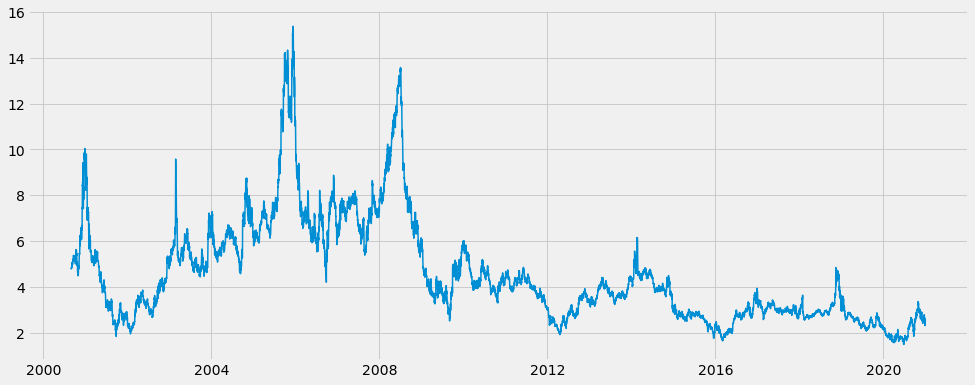

In [67]:
plt.figure(figsize=(15,6))
mpl.rcParams['lines.linewidth'] = 1.5
plt.plot(train_df['Close'])
plt.show()

In [68]:
data = np.log(train_df['Close'])

## Average of the data

In [69]:
def average(series):
    return round(np.mean(series), 2)

In [70]:
print(f"Average of the given series: {average(data)}")

Average of the given series: 1.41


## Moving average

In [71]:
def moving_average(series, n):
    return round(np.mean(series[-n:]), 2)

In [72]:
print(f"Movigng Average of the past year: {moving_average(data, 253)}")

Movigng Average of the past year: 0.79


In [73]:
def calc_conf_inv(pred, level):
    '''function to calculate confidence intervals for given significance level'''
    alpha_dct = {90:1.64, 95:1.96, 96:2.05, 97:2.17, 98:2.33, 99:2.58}
    alpha = alpha_dct[level]
    
    stdev = np.std(pred)
    uncertainity = alpha*stdev
    
    lower_bound = pred - uncertainity
    upper_bound = pred + uncertainity
    
    results = pd.DataFrame({'Predictions':pred, 'Lower Bound':lower_bound, 'Upper Bound':upper_bound})
    
    return results

In [74]:
def plot_moving_avg(series, window, conf_level):
    rolling_mean = series.rolling(window=window).mean()
    
    results = calc_conf_inv(rolling_mean, conf_level)
    
    fig, ax = plt.subplots()
    ax.set_title('Moving average\n window size = {}'.format(window))
    ax.plot(results['Predictions'], label='Rolling mean trend')
    
    ax.fill_between(results.index, results['Lower Bound'], results['Upper Bound'], alpha=0.2)

    ax.plot(series[window:], label='Actual values')
    ax.legend(loc='best')
    ax.grid(True)

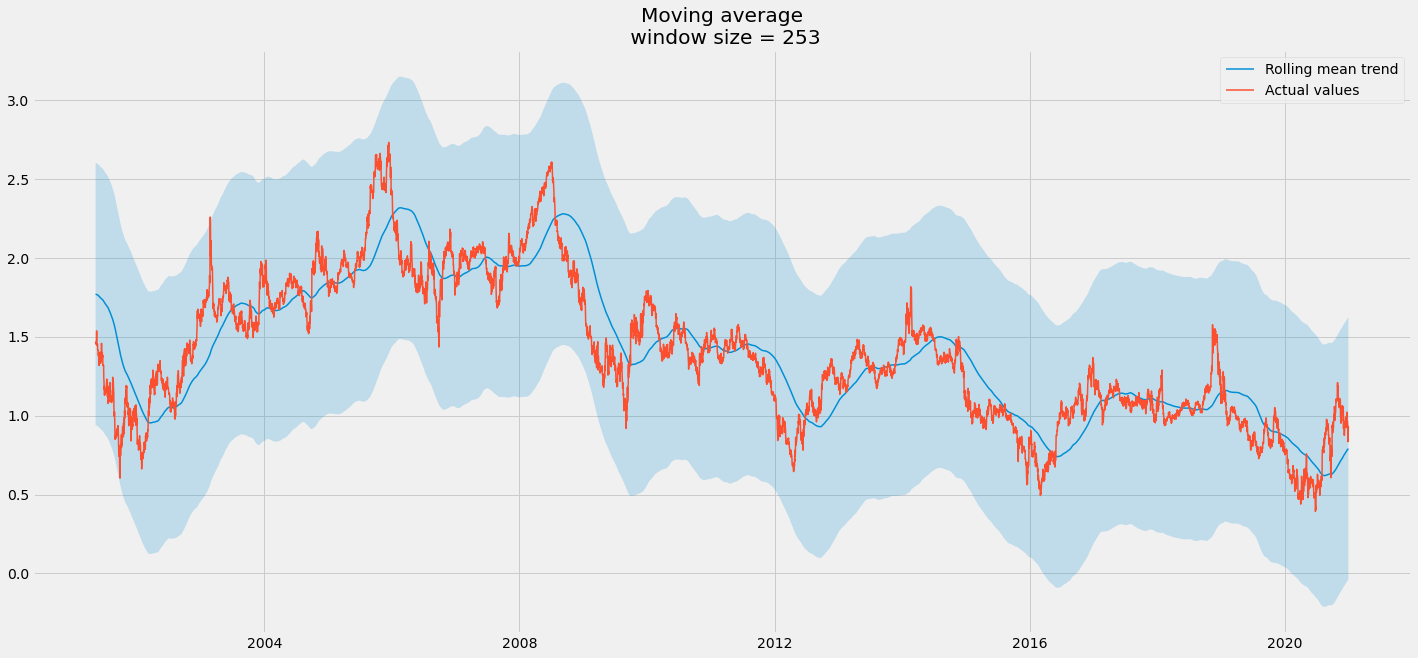

In [75]:
plot_moving_avg(data, window=253, conf_level=95)

## Decomposition of Time Series

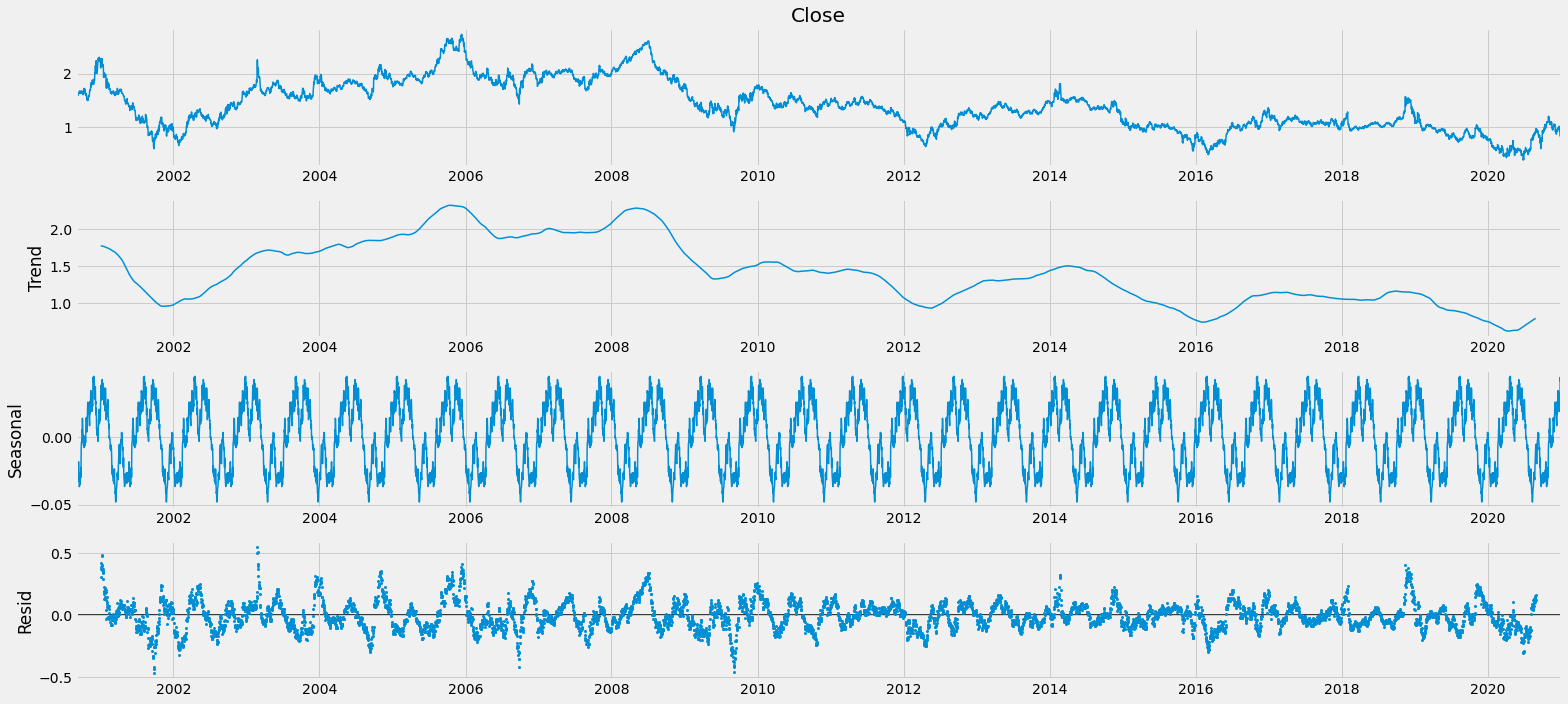

In [76]:
decomp = seasonal_decompose(data, period=253)
mpl.rcParams['lines.markersize'] = 2
figure = decomp.plot()
plt.show()

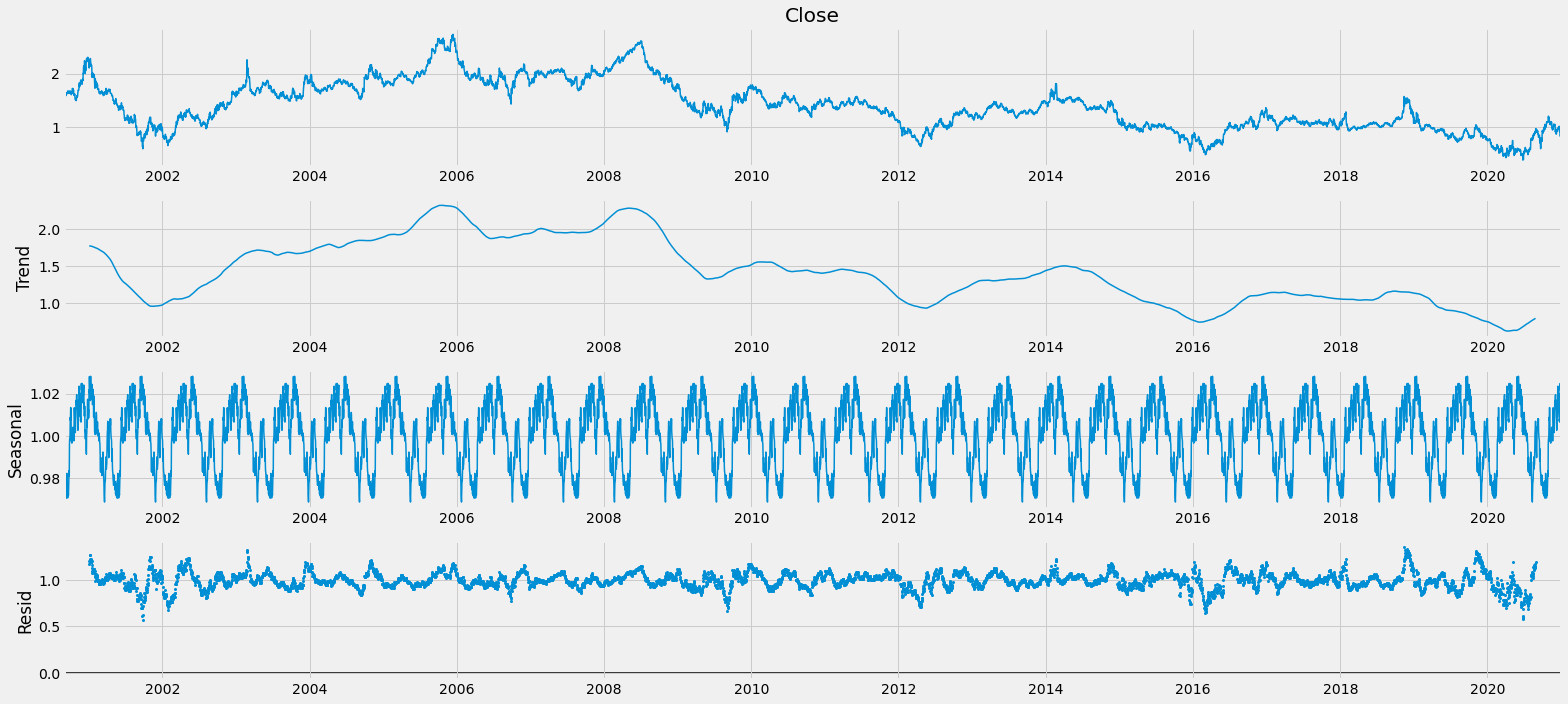

In [77]:
decomp_mul = seasonal_decompose(data, period = 253, model="multiplicative")
mpl.rcParams['lines.markersize'] = 2
figure = decomp_mul.plot()
plt.show()

## Exponential Smoothing

### Train-Test Split for exponential smoothing

In [78]:
data.tail()

All_date
2020-12-27    0.947847
2020-12-28    0.835081
2020-12-29    0.903003
2020-12-30    0.884594
2020-12-31    0.931770
Name: Close, dtype: float64

In [148]:
train = data
val = pd.read_csv("dataset/ngp_val.csv")[["Date", "Close"]]
test= pd.read_csv("dataset/ngp_test.csv")[["Date", "Close"]]

In [149]:
val['Date'] = pd.to_datetime(val['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [150]:
val = val.set_index('Date')
test = test.set_index('Date')

In [151]:
val = np.log(val)
test = np.log(test)

In [152]:
forecast_len = len(val)

In [163]:
def fit_simple_exp_smoothing(alpha_sm, conf_level):
    model_fit = SimpleExpSmoothing(train).fit(smoothing_level = alpha_sm, optimized=False)
    
    forecasts = model_fit.forecast(forecast_len).rename('alpha = ' + str(alpha_sm))
    forecasts.index= val.index
    
    fitted_values = model_fit.fittedvalues
    fitted_values.index=train.index
    
    results = calc_conf_inv(forecasts, conf_level)
    
    return fitted_values, results, model_fit.aic

In [164]:
def plot_exp_smoothing(exp_smoothing, param, conf_level, title=None):
    fitted_values, res, aic = exp_smoothing(param, conf_level)
    
    rmse = np.sqrt(mean_squared_error(val, res['Predictions']))
    
    fig, ax = plt.subplots()
    ax.set_title(title)

    ax.plot(train, label='Train')
    ax.plot(fitted_values, label='Fitted Values')
    
    ax.plot(res['Predictions'], label='Forecast', color='black')
    ax.fill_between(res.index, res['Lower Bound'], res['Upper Bound'], alpha=0.4)

    ax.plot(val, label="Val (RMSE={:0.2f}, AIC={:0.2f})".format(rmse, aic), color='green')
    
    ax.legend(loc='best')
    ax.grid(True)
    plt.show()

In [217]:
def plot_from_res(train, test, fitted_values, pred, aic, conf_level, title=None):
    res = calc_conf_inv(pred, conf_level)
    rmse = mean_squared_error(val, res['Predictions'], squared=False)
    
    fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.plot(train, label='Train')
    ax.plot(fitted_values, label='Fitted Values')
    
    ax.plot(res['Predictions'], label='Forecast', color='black')
    ax.fill_between(res.index, res['Lower Bound'], res['Upper Bound'], alpha=0.4)

    ax.plot(test, label="Test (RMSE={:0.2f}, AIC={:0.2f})".format(rmse, aic), color='green')
    
    ax.legend(loc='best')
    ax.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Prices($)')
    plt.show()

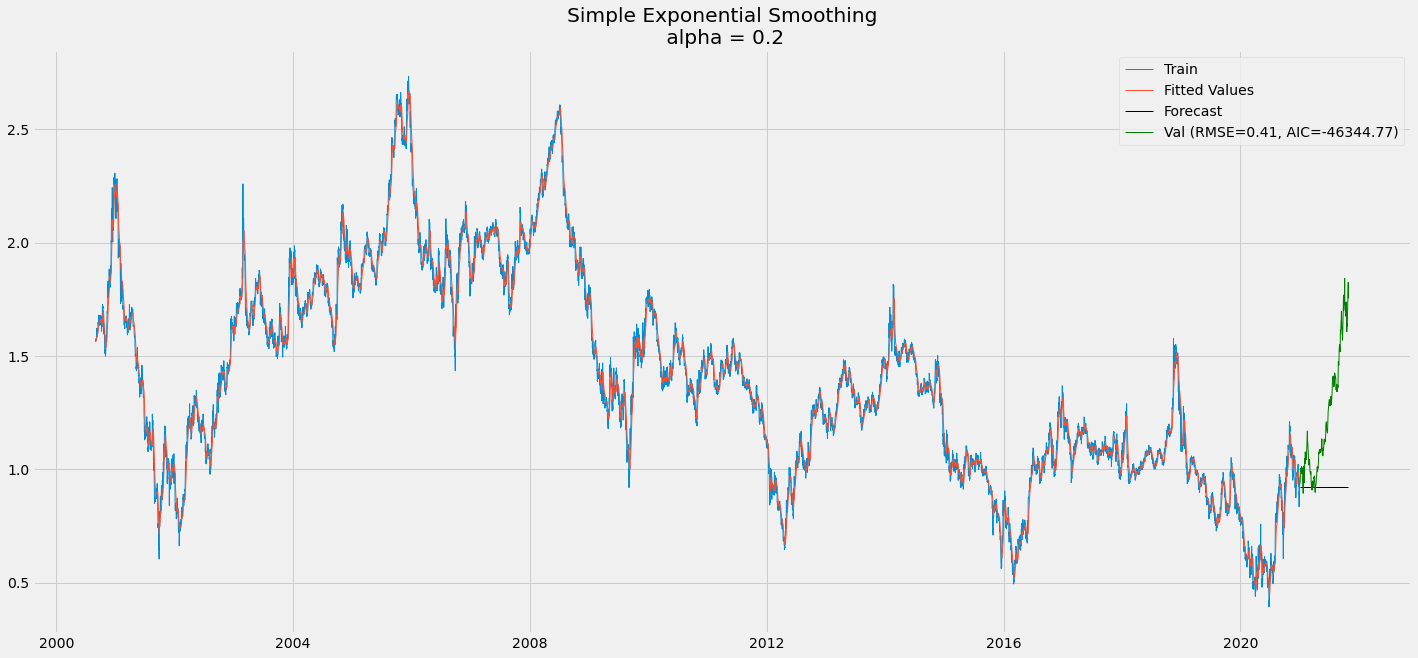

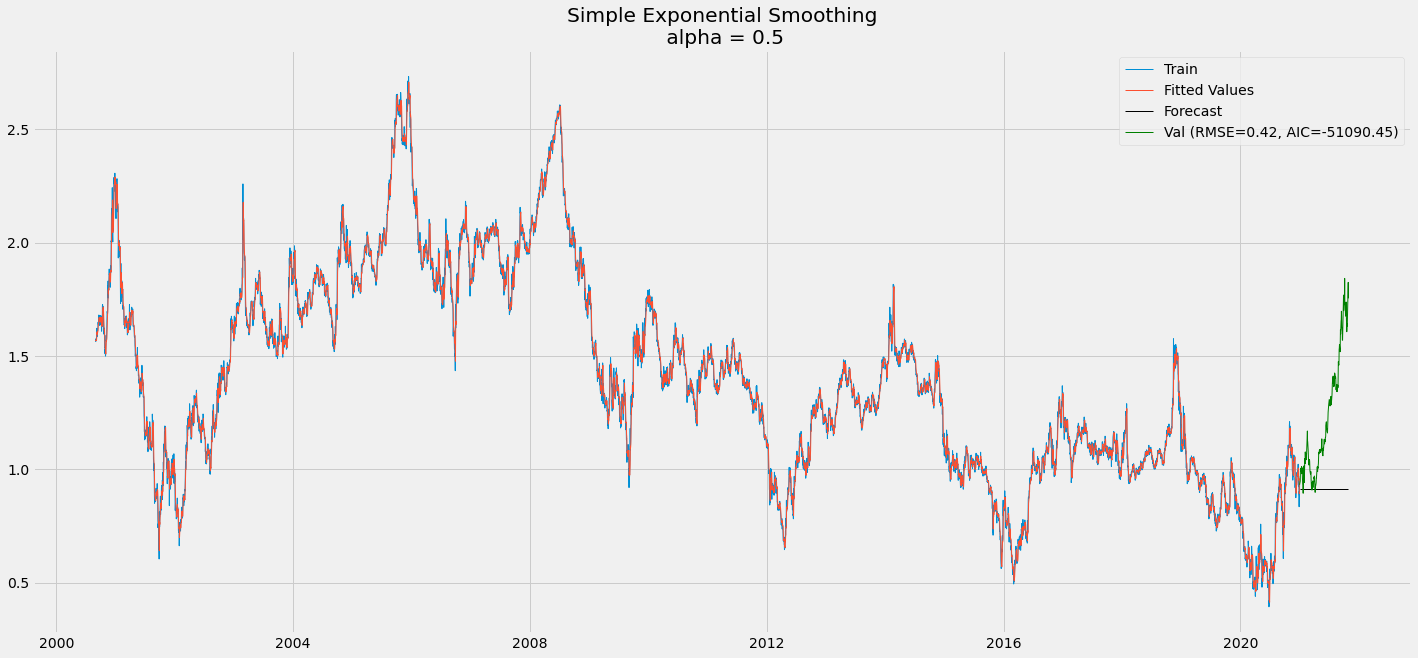

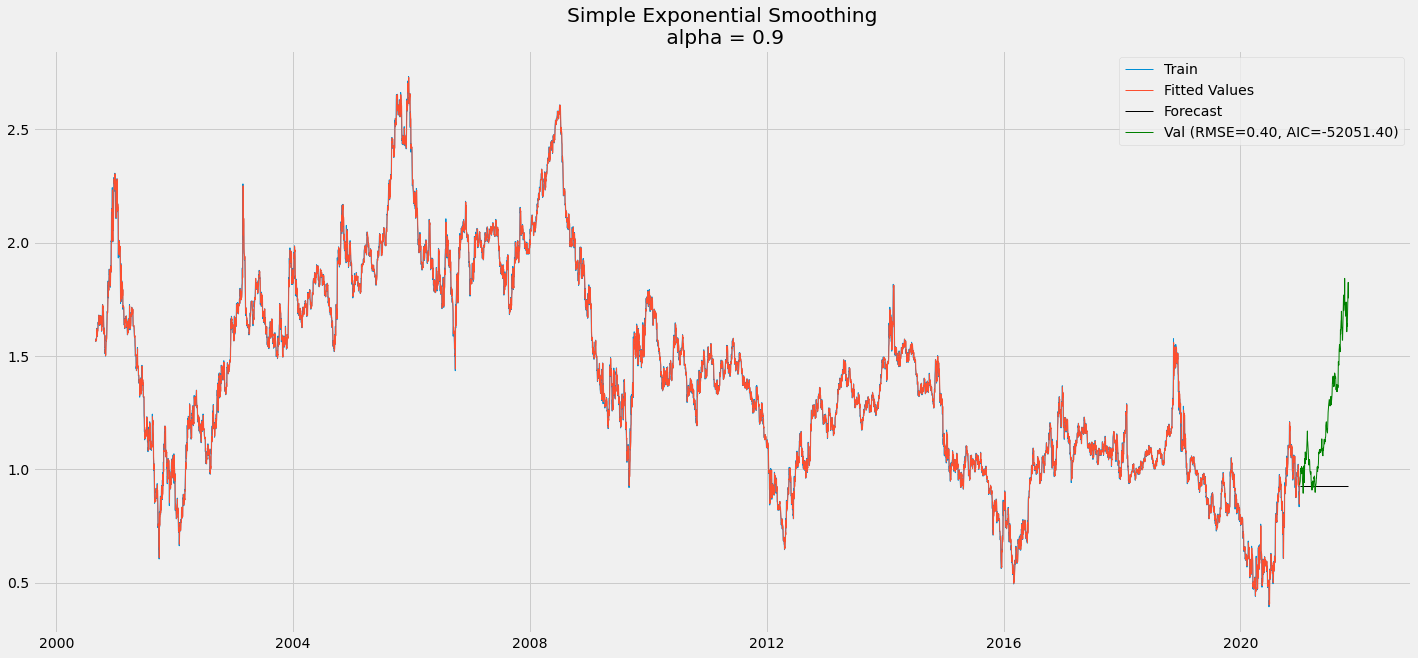

In [166]:
for alpha_sm in [0.2 , 0.5, 0.9]:
    plot_exp_smoothing(fit_simple_exp_smoothing, alpha_sm, 95, f"Simple Exponential Smoothing\n alpha = {alpha_sm}")

### Double Exponential Smoothing

In [167]:
def fit_double_exp_smoothing(param, conf_level):
    model_fit = Holt(train).fit(smoothing_level=param[0], smoothing_slope=param[1], optimized=False)
    
    forecasts = model_fit.forecast(forecast_len).rename("Holt's linear trend")
    forecasts.index= val.index
    
    fitted_values = model_fit.fittedvalues
    
    results = calc_conf_inv(forecasts, conf_level)
    
    return fitted_values, results, model_fit.aic

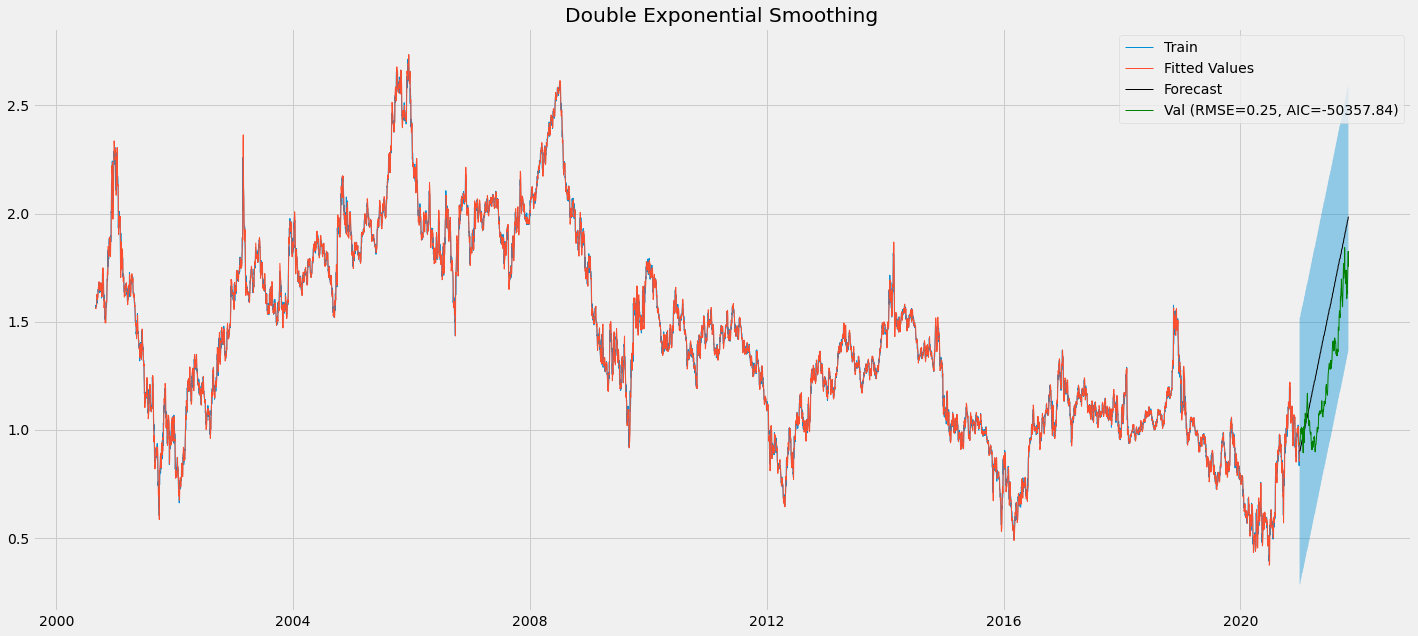

In [168]:
plot_exp_smoothing(fit_double_exp_smoothing, [0.5, 0.5], 95, f"Double Exponential Smoothing")

### Triple Exponential Smoothing

In [169]:
def fit_triple_exp_smoothing(param, conf_level):
    model = ExponentialSmoothing(train, seasonal_periods=253, trend='mul', seasonal='mul')
    model_fit = model.fit(smoothing_level=param[0], smoothing_trend=param[1], smoothing_seasonal=param[2])
    
    forecasts = model_fit.forecast(forecast_len).rename("Holt-Winters smoothing")
    forecasts.index= val.index
    
    fitted_values = model_fit.fittedvalues
    
    results = calc_conf_inv(forecasts, conf_level)
    
    return fitted_values, results, model_fit.aic

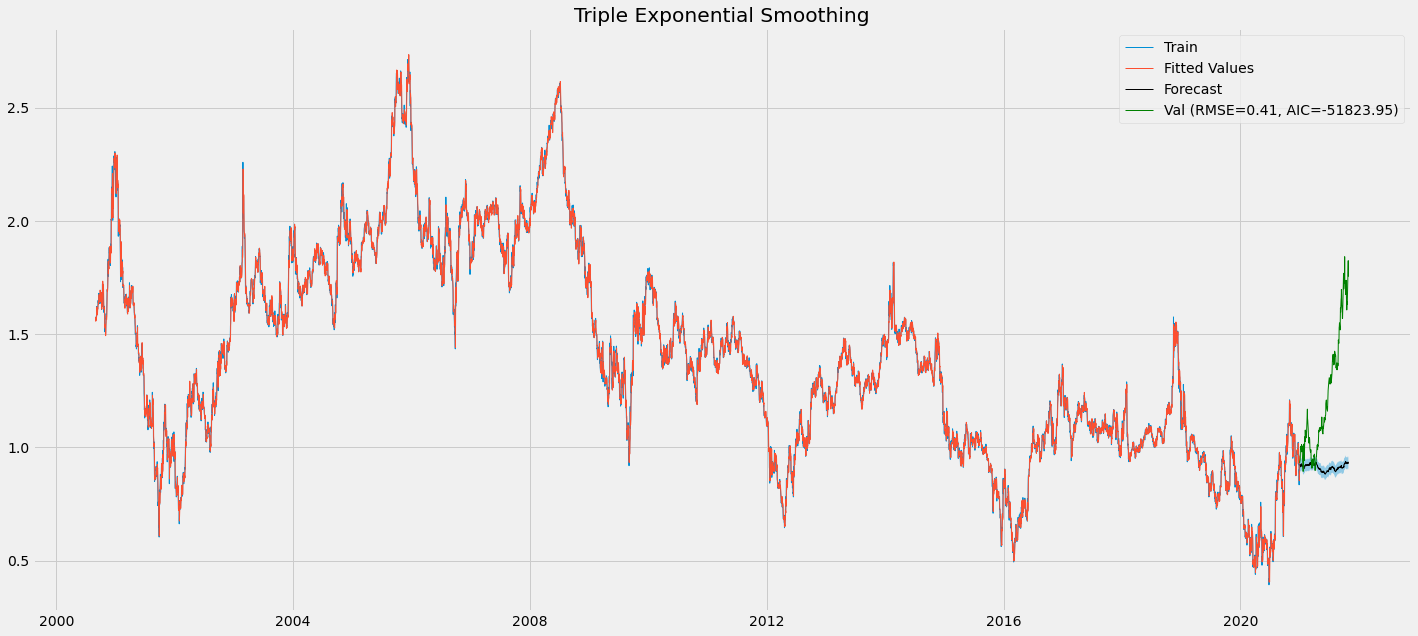

In [170]:
plot_exp_smoothing(fit_triple_exp_smoothing, [None, None, None], 95, f"Triple Exponential Smoothing")

## Searching for best parameters

In [171]:
def timeseries_cv_score(params, series, loss_function, season_len=253, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits, test_size=250)

    for train_idx, test_idx in time_series_split.split(series):
        model = ExponentialSmoothing(series[train_idx], seasonal_periods=253, trend='mul', seasonal='mul')
        model_fit = model.fit(smoothing_level = params[0], smoothing_trend = params[1], smoothing_seasonal=params[2])

        # evaluate the prediction on the test set only
        test_predictions = model_fit.forecast(len(test_idx))
        test_actual = series[test_idx]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

In [172]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 20 points of our time series as test set
%timeit
params = [0, 0, 0]
opt = minimize(timeseries_cv_score, x0=params, 
               args=(data, mean_absolute_percentage_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(params)))

original parameters: [0, 0, 0]


best parameters: [1.93221871e-04 0.00000000e+00 6.88600110e-07]


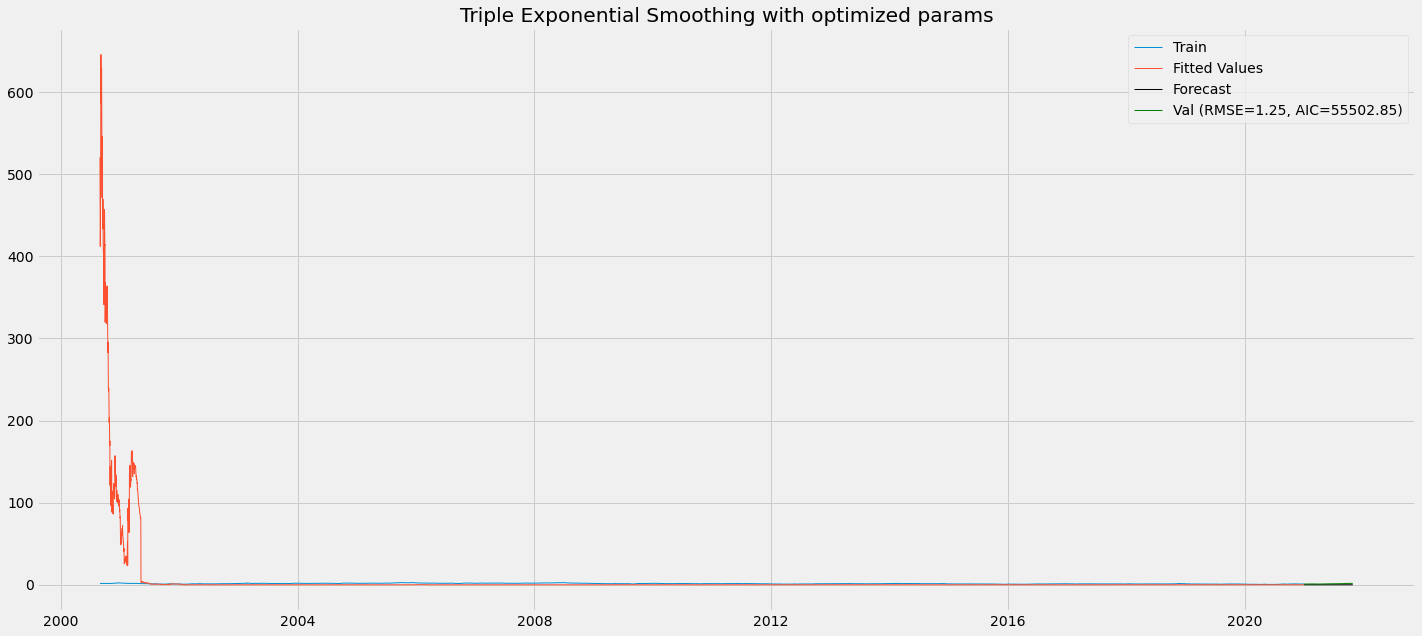

In [173]:
# retrieve optimal values, train the finnal model with them
#params = [1.77996222e-07, 1.02554061e-08, 1.25315560e-07]
print('best parameters: {}'.format(str(opt.x)))

params = opt.x
plot_exp_smoothing(fit_triple_exp_smoothing, params, 95,
                   f"Triple Exponential Smoothing with optimized params")

## Using ETS Model

In [174]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [175]:
ets_model = ETSModel(
    endog=train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=253,
)

In [176]:
ets_result = ets_model.fit()

In [179]:
val_preds = ets_result.forecast(len(val))

In [180]:
val_preds.index=val.index

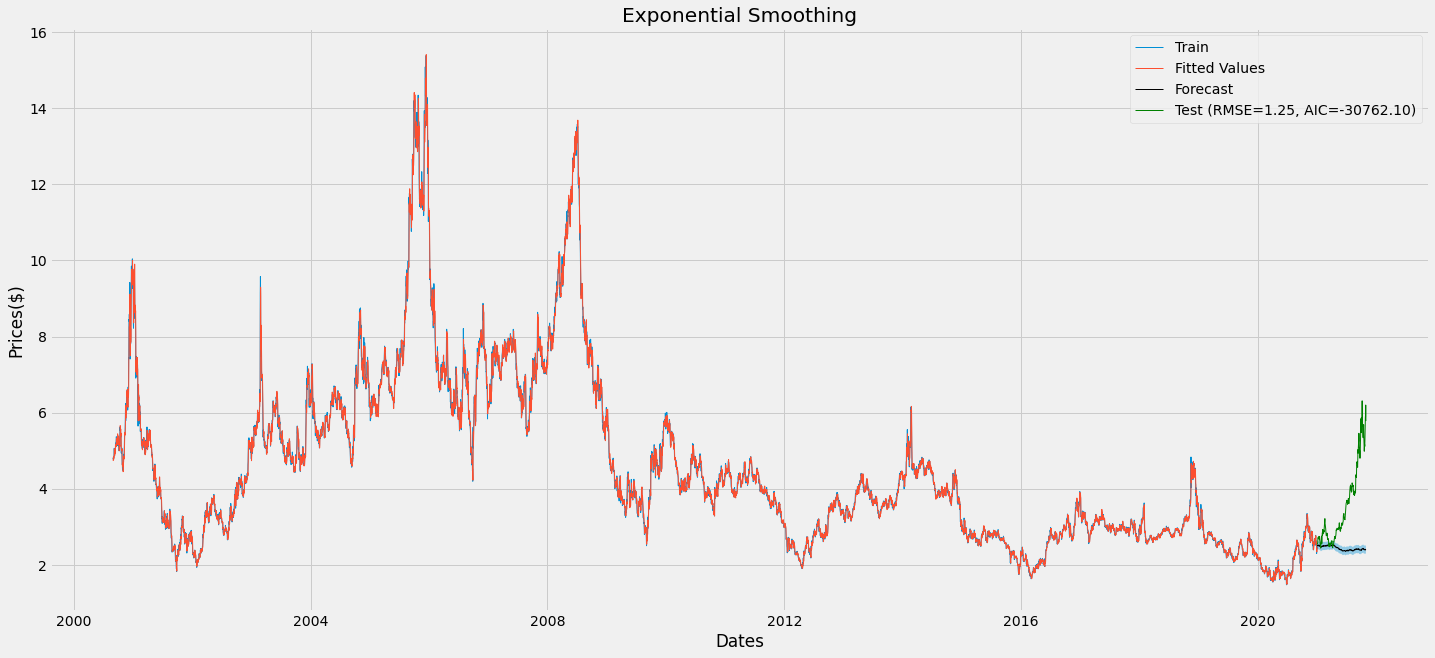

In [218]:
plot_from_res(np.exp(train), np.exp(val), np.exp(ets_result.fittedvalues), np.exp(val_preds), ets_result.aic, 95, "Exponential Smoothing")

In [184]:
dict(zip(ets_model.param_names, ets_model.start_params[:3]))

{'smoothing_level': 0.1, 'smoothing_trend': 0.01, 'smoothing_seasonal': 0.01}

In [208]:
test_preds = ets_result.forecast(418)

In [211]:
np.exp(test_preds).to_csv("preds/ensemble/es test_preds.csv")

In [214]:
np.exp(test_preds).to_csv("preds/ensemble/es test_preds.csv")

## Train, Val and Test Preds

In [193]:
pd.Series(np.exp(ets_result.fittedvalues)).to_csv("preds/es train preds.csv")

In [194]:
pd.Series(np.exp(val_preds)).to_csv("preds/es val preds.csv")

In [195]:
pd.Series(np.exp(test_preds)).to_csv("preds/es test preds.csv")

In [196]:
start = datetime(2021,1,1)
end = datetime(2026,1,1)

In [197]:
dates = pd.date_range(start=start,end=end)

In [198]:
forcast_len = len(dates)
forcast_len

1827

In [199]:
result = np.exp(ets_result.forecast(forcast_len))

In [200]:
result.index = dates

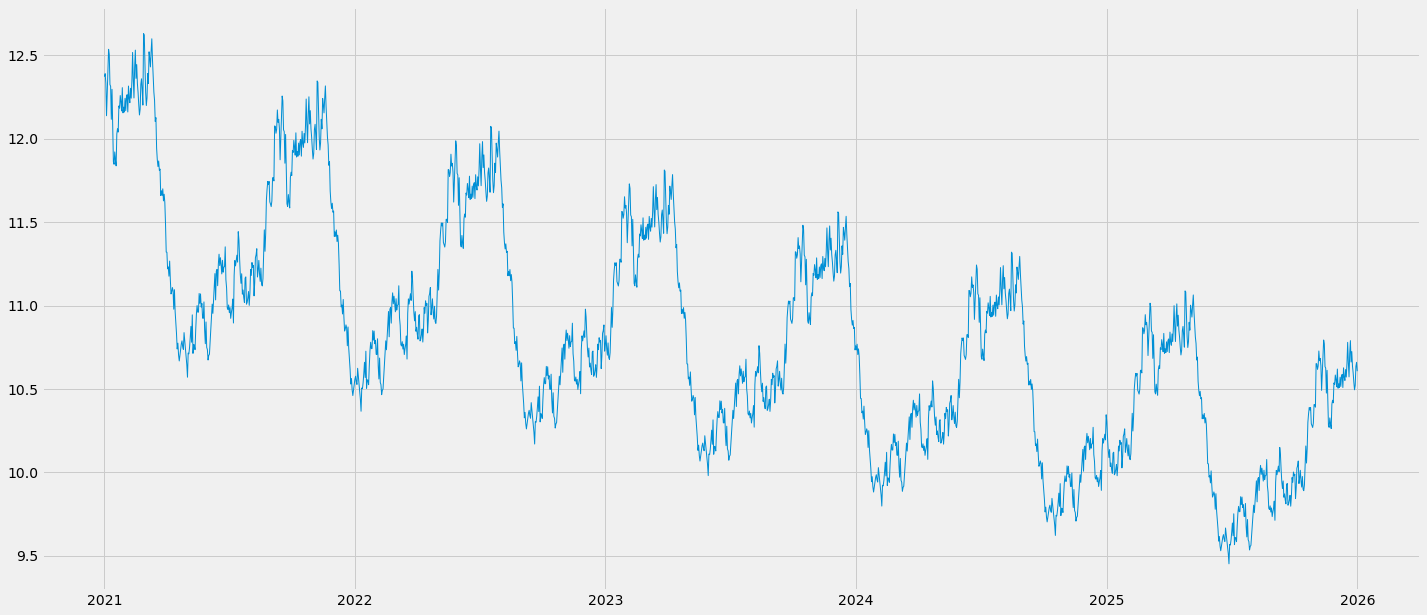

In [202]:
# plot_from_res(train, test, ets_result.fittedvalues, result, ets_result.aic, 95, "ETS")
plt.plot(np.exp(result))
plt.show()

In [203]:
conf = calc_conf_inv(np.exp(result),95)

In [204]:
conf.to_csv("Exponential Smoothing.csv")

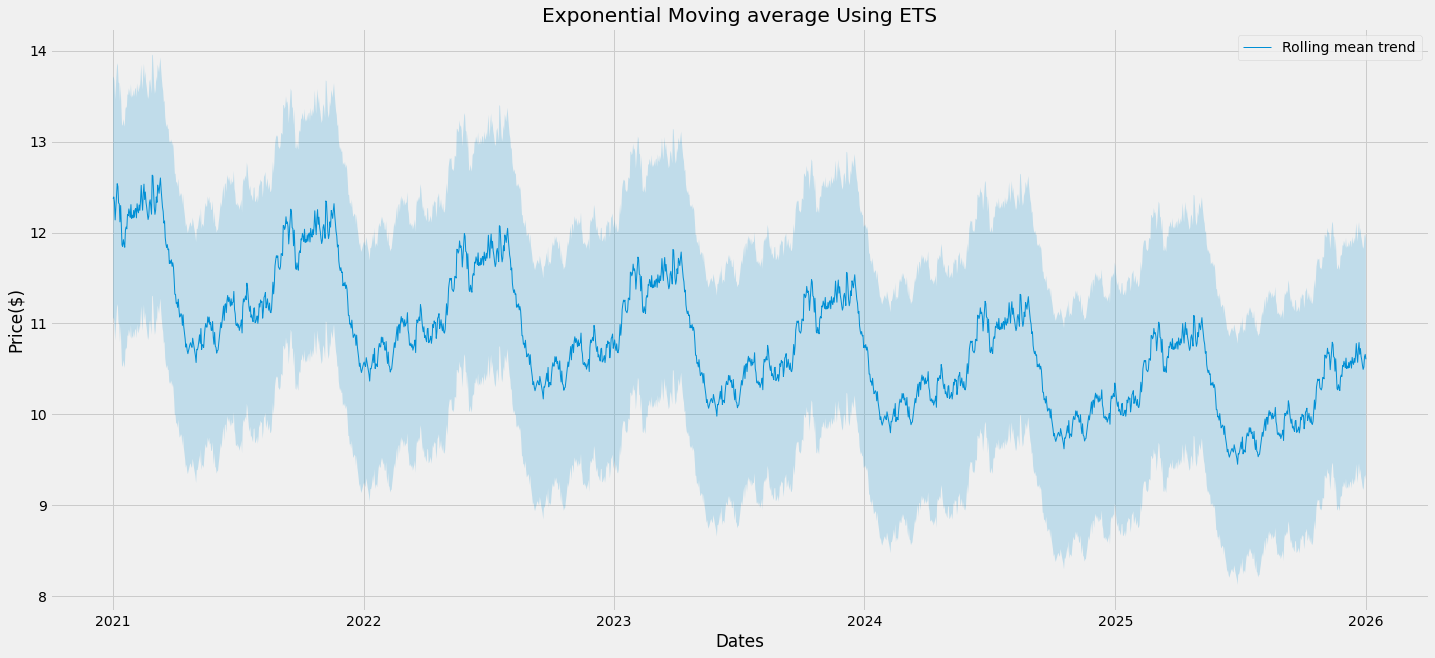

In [205]:
fig, ax = plt.subplots()
ax.set_title('Exponential Moving average Using ETS'.format(""))
ax.plot(conf['Predictions'], label='Rolling mean trend')

ax.fill_between(conf.index, conf['Lower Bound'], conf['Upper Bound'], alpha=0.2)
ax.legend(loc='best')
plt.xlabel("Dates")
plt.ylabel("Price($)")
plt.show()